# **3D Detection pipeline**
___  
  
In this notebook we show how to apply a [BiaPy](https://biapy.readthedocs.io/en/latest/) pipeline for **3D detection** of microscopy data.

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/detection_image_input.png' width='300px'/>
<img src='https://biapy.readthedocs.io/en/latest/_images/detection_csv_input.svg' width='300px'/>
<figcaption><b>Figure 1</b>: Example of a 3D detection problem. From left to right: 3D brainbow image and its corresponding CSV file with the coordinates of the center of each cell. </figcaption></center>
</figure>

**Without any coding**, we explain step by step how to
1. **upload a set of training and test images** with their coordinates of the center of each cell,
2. **train a deep neural network (DNN)** model on the training set, 
3. **apply the model** to the test images, and 
4. **download the detection results** to your local machine.

**Disclaimer:** the structure of the notebook is heavily inspired in the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook has been made by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus) and [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org). If you have any suggestion or comment, or find any problem, please write us an email or [create an issue in BiaPy's repository](https://github.com/danifranco/BiaPy/issues). Thanks!

## **Expected inputs and outputs**
___
**Inputs**

This notebook expects five folders as input:
* **Training raw images**: with the raw 3D images to train the model.
* **Training csv files**: with the coordinates of the center of each cell to train the model. Their number and sizes must match those of the training raw images.
* **Test raw images**: with the raw 3D images to test the model.
* **Test csv files**: with the coordinates of the center of each cell to test the model. Their number and sizes must match those of the validation raw images.
* **Output folder**: a path to store the segmentation results.

**Outputs**

If the execution is successful, a folder will be created containing one result **CSV file** and a **TIFF image** for each test image. The CSV files contain the coordinates of the center of each cell and the result images contain those central points as predicted by our pipeline.

<font color='red'><b>Note</b></font>: for testing purposes, you can also run this notebook with the **example datasets provided in 'Manage file(s) source > Option 3'**.






## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Manage file(s) source**
---
The input folder can be provided using three different options: by directly uploading the folder (option 1), by using a folder stored in Google Drive (option 2) or by using a few samples of our data (option 3).

Depending on the option chosen, different steps will have to be taken, as explained in the following cells.


### **Option 1: use your local files and upload them to the notebook**
---
You will be prompted to upload your files to Colab and they will be stored under `/content/input/`.

In [ ]:
#@markdown ##Play the cell to upload local files (train raw images)
from google.colab import files
!mkdir -p /content/input/train/x
%cd /content/input/train/x
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload csv files (instance coordinates)

from google.colab import files
!mkdir -p /content/input/train/y 
%cd /content/input/train/y
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (test raw images)

from google.colab import files
!mkdir -p /content/input/val/x
%cd /content/input/val/x
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload csv files (instance coordinates)

from google.colab import files
!mkdir -p /content/input/val/y
%cd /content/input/val/y
uploaded = files.upload()
%cd /content

### **Option 2: mount your Google Drive**
---
To use this notebook on your own data from Google Drive, you need to mount Google Drive first.

Play the cell below to mount your Google Drive and follow the link that will be shown. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive. 

Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: download an example dataset**
---
If you do not have data at hand but would like to test the notebook, no worries! You can run the following cell to download an example dataset.

In particular, we will use the training set of [NucMM-Z](https://arxiv.org/abs/2107.05840) publicly available online. This dataset is for instance segmentation but we create the CSV file of each instance center so we can use it in this workflow.

In [ ]:
#@markdown ##Play to download an example dataset

import os

os.chdir('/content/')
!curl -L -s -o NucMM-Z_training.zip 'https://drive.google.com/uc?id=19P4AcvBPJXeW7QRj92Jh1keunGa5fi8d&confirm=t'
!unzip -q NucMM-Z_training.zip
!rm NucMM-Z_training.zip

print( 'Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data



## **Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelerator: GPU** *(Graphics processing unit)*

## **Paths to load input images and save output files**
___

If option 1 (uploading the folder) or option 3 (downloading our prepared data samples) were chosen, define train_data_path as '/content/data/train/x', train_data_mask_path as '/content/data/train/y', test_data_path as '/content/data/test/x', test_data_mask_path as '/content/data/test/y', and output_path as '/content/out'. Please make sure you download the results from the '/content/out' folder later!

If option 2 is chosen, introduce here the paths to your input files and to the folder where you want to store the results. E.g. '/content/gdrive/MyDrive/...'.

In case you have troubles finding the path to your folders, at the top left of this notebook you will find a small folder icon. Explore until you find the folders. There you can copy the folder path by right clicking and clicking "copy".

In [ ]:
#@markdown #####Path to train images
train_data_path = '/content/data/train/x' #@param {type:"string"}
#@markdown #####Path to train CSV files
train_csv_path = '/content/data/train/y' #@param {type:"string"}
#@markdown #####Path to test images
test_data_path = '/content/data/test/x' #@param {type:"string"}
#@markdown #####Path to test CSV files
test_csv_path = '/content/data/test/y' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Install BiaPy library**


In [ ]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
from skimage.exposure import match_histograms                                                                           

# Clone the repo
os.chdir('/content/')
if not os.path.exists('BiaPy'):
    !git clone https://github.com/danifranco/BiaPy.git
    !pip install --upgrade --no-cache-dir gdown &> /dev/null
    sys.path.insert(0, 'BiaPy')
    os.chdir('/content/BiaPy')
    
    # Install dependencies 
    !pip install git+https://github.com/aleju/imgaug.git &> /dev/null
    !pip install numpy_indexed yacs fill_voids edt &> /dev/null
else:
    print( 'Using existing installed version of BiaPy' )

Cloning into 'BiaPy'...
remote: Enumerating objects: 15852, done.
remote: Counting objects: 100% (1921/1921), done.
remote: Compressing objects: 100% (635/635), done.
remote: Total 15852 (delta 1353), reused 1830 (delta 1267), pack-reused 13931
Receiving objects: 100% (15852/15852), 823.97 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (8622/8622), done.


## **Configure and train the DNN model**
In this workflow [BiaPy](https://biapy.readthedocs.io/en/latest/) tries to to localize objects in the input image capturing individual points at their center of mass ([Zhou et. al](https://arxiv.org/abs/1904.07850)). To do so we create a mask with the points in the CSV to train the network. To decide the size of the central points the variable **central_point_dilation** is used. In case of 3D images, only in the middle slice of the object is considered to be the central point. 


### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Data management**
* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`test_ground_truth`:** Select to use test data ground truth to measure the performance of the model's result. If selected, **test_data_mask_path** variable path set above will be used. **Default value: True**

#### **Basic training parameters**
* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. For the example dataset, preliminary results can already be observed after 50 epochs, but better results are obtained when running the model longer. **Default value: 100**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:**  Select the architecture of the DNN used as backbone of the pipeline. Options: U-Net, Residual U-Net, Attention U-Net, SEUNet (see [Franco-Barranco et al., 2021](https://link.springer.com/article/10.1007/s12021-021-09556-1)) (see [Franco-Barranco et al., 2021](https://link.springer.com/article/10.1007/s12021-021-09556-1))  **Default value: Residual U-Net**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 8**

* **`patch_size_xy`:** Input the XY size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 64**

* **`patch_size_z`:** Input the Z size of the patches use to train your model (length in pixels in Z). The value should be smaller or equal to the dimensions of the image. **Default value: 64**

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 1**

* **`anisotropic_data`:** Select if your image data is anisotropic (lower resolution in Z with respect to XY). The model downsampling step size will be set accordingly. **Default value: False**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, Stocastic Gradient Descent (SGD). ADAM converges usually faster but SGD is known for better generalization. **Default value: ADAM**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM as optimizer, this value should be around 10e-4. **Default value: 0.0001**

* **`test_time_augmentation`:** Select to apply augmentation (flips and rotations) at test time. It usually provides more robust results but uses more time to produce each result. **Default value: False**

* **`min_value_to_be_peak`:** Minimun value to consider a point as a peak. This value needs to between 0 and 1. **Default value: 0.2**

* **`resolution_xy`:** Data resolution in for y and x axis. **Default value: 0.51**

* **`resolution_z`:** Data resolution in for z axis. **Default value: 0.48**

#### **Advanced Parameters of Detection - experienced users only**

* **`central_point_dilation`:** Size of the disk that will be used to dilate the central point created from the CSV file to train the network. Set it to 0 to not dilate and only create a 3x3 square. Normally it is set to 3 but here we set it to 0 because the nuclei of this dataset are very small. **Default value: 0**

* **`tolerance`:** Maximum distance far away from a GT point to consider a point as a true positive. **Default value: 3**

* **`remove_close_points`:** Distance between points to be considered the same so only one will be kept. **Default value: True**

* **`remove_close_points_radius`:** Maximum distance far away from a GT point to consider a point as a true positive. **Default value: 3**



In [ ]:
#@markdown ###Name of the model:
model_name = "my_3d_detection" #@param {type:"string"}

#@markdown ### Data management:
test_ground_truth = True #@param {type:"boolean"}
percentage_validation =  10 #@param {type:"number"}

#@markdown ### Basic training parameters:
number_of_epochs =  100#@param {type:"number"}
patience =  20#@param {type:"number"}

#@markdown ### Advanced training parameters:

model_architecture = "Residual U-Net" #@param ["U-Net", "Residual U-Net", "Attention U-Net", 'SEUNet']

batch_size =  8#@param {type:"number"}
patch_size_xy = 64 #@param {type:"number"}
patch_size_z = 64 #@param {type:"number"}
resolution_xy = 0.51 #@param {type:"number"}
resolution_z = 0.48 #@param {type:"number"}

input_channels = 1 #@param {type:"number"}
anisotropic_data = True #@param {type:"boolean"}

optimizer = "ADAM" #@param ["ADAM", "SGD"]
initial_learning_rate = 0.0001 #@param {type:"number"}

test_time_augmentation = False #@param {type:"boolean"}

#@markdown ### Advanced Parameters of Detection: 
central_point_dilation = 0 #@param {type:"number"}
min_value_to_be_peak = 0.2 #@param {type:"number"}
tolerance = 3 #@param {type:"number"}
remove_close_points = True #@param {type:"boolean"}
remove_close_points_radius= 3 #@param {type:"number"}


In [ ]:
#@markdown ##Play to download the YAML configuration file and update it to train the model
import errno

os.chdir('/content/') 

job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '3d_detection.yaml'
if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file 
!wget https://raw.githubusercontent.com/danifranco/BiaPy/master/templates/detection/3d_detection.yaml &> /dev/null

# Check folders before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[2])
if len(ids) == 0:
    raise ValueError("No csv files in dir {}".format(train_data_path))
if not os.path.exists(train_csv_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_csv_path)
ids = sorted(next(os.walk(train_csv_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_csv_path))

# Check folders before modifying the .yaml file
if not os.path.exists(test_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_path)
ids = sorted(next(os.walk(test_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(test_data_path))
if not os.path.exists(test_csv_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_csv_path)
ids = sorted(next(os.walk(test_csv_path))[2])
if len(ids) == 0:
    raise ValueError("No csv files in dir {}".format(test_csv_path))


# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

biapy_config['SYSTEM']['NUM_CPUS'] = -1
biapy_config['PROBLEM']['DETECTION'] = {}
biapy_config['PROBLEM']['DETECTION']['CENTRAL_POINT_DILATION'] = central_point_dilation

# update paths to data
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TRAIN']['MASK_PATH'] = train_csv_path
biapy_config['DATA']['TEST']['PATH'] = test_data_path
biapy_config['DATA']['TEST']['MASK_PATH'] = test_csv_path
biapy_config['DATA']['TEST']['LOAD_GT'] = test_ground_truth

# make sure ground truth labels are loaded
biapy_config['DATA']['TEST']['LOAD_GT'] = True

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size_z)+', '+ str(patch_size_xy)+', '+ str(patch_size_xy)+ ', ' + str(input_channels)+')'
# adjust test padding accordingly
padding_xy = patch_size_xy // 8
padding_z = patch_size_z // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+str(padding_z)+', '+ str(padding_xy)+', '+ str(padding_xy)+')'
biapy_config['DATA']['TEST']['RESOLUTION'] = '('+str(resolution_z)+', '+ str(resolution_xy)+', ' + str(resolution_xy)+')'

# update training parameters
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# Transcribe model architecture
# Available models: "U-Net", "Residual U-Net", "Attention U-Net", 'SEUNet'
architecture = 'unet'
if model_architecture == "U-Net":
    architecture = 'unet'
elif model_architecture == "Residual U-Net":
    architecture = 'resunet'
elif model_architecture == "Attention U-Net":
    architecture = 'attention_unet'
elif model_architecture == "SEUNet":
    architecture = 'seunet'
biapy_config['MODEL']['ARCHITECTURE'] = architecture
if anisotropic_data == True:
    biapy_config['MODEL']['Z_DOWN'] = [1 for i in range(len(biapy_config['MODEL']['FEATURE_MAPS'])-1)]
else:
    biapy_config['MODEL']['Z_DOWN'] = [2 for i in range(len(biapy_config['MODEL']['FEATURE_MAPS'])-1)]

# update test parameters
biapy_config['TEST']['AUGMENTATION'] = test_time_augmentation

# Detection parameters
biapy_config['TEST']['DET_MIN_TH_TO_BE_PEAK'] = [min_value_to_be_peak]
biapy_config['TEST']['DET_TOLERANCE'] = [tolerance]
biapy_config['TEST']['POST_PROCESSING']['REMOVE_CLOSE_POINTS'] = remove_close_points
biapy_config['TEST']['POST_PROCESSING']['REMOVE_CLOSE_POINTS_RADIUS'] = [remove_close_points_radius]

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

Training configuration finished.


### **Train the model**
---

In [ ]:
#@markdown ##Play to train the model

import os
import errno

# Run the code 
os.chdir('/content/BiaPy')
!python -u main.py --config '/content/'{job_name}'.yaml' --result_dir {output_path} --name {job_name} --run_id 1 --gpu 0



Date: 2023-02-09 09:14:03
Arguments: Namespace(config='/content/my_3d_detection.yaml', gpu='0', name='my_3d_detection', result_dir='/content/output', run_id=1)
Job: my_3d_detection_1
Python       : 3.8.10 (default, Nov 14 2022, 12:59:47) 
Keras        : 2.9.0
Tensorflow   : 2.9.2
Num GPUs Available:  1
Configuration details:
AUGMENTOR:
  AFFINE_MODE: constant
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_EM: False
  BRIGHTNESS_EM_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_EM_MODE: 3D
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_EM: False
  CONTRAST_EM_FACTOR: (-0.1, 0.1)
  CONTRAST_EM_MODE: 3D
  CONTRAST_FACTOR: (-0.1, 0.1)
  CONTRAST_MODE: 3D
  COUT_APPLY_TO_MASK: False
  COUT_CVAL: 0
  COUT_NB_ITERATIONS: (1, 3)
  COUT_SIZE

## Inspection of the loss function and the Intersection over Union (IoU)
---

First, it is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.

During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

Decreasing **Training loss** and **Validation loss** indicates that training is still necessary and increasing the `number_of_epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **Validation loss** suddenly increases again an the **Training loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.

The **Jaccard index or Intersection over Union** (IoU) metric is a method that can be used to quantify the overlap between the target mask and your prediction output. **Therefore, the closer to 1, the better the performance.** This metric can be used to assess the quality of your model to accurately predict cells.

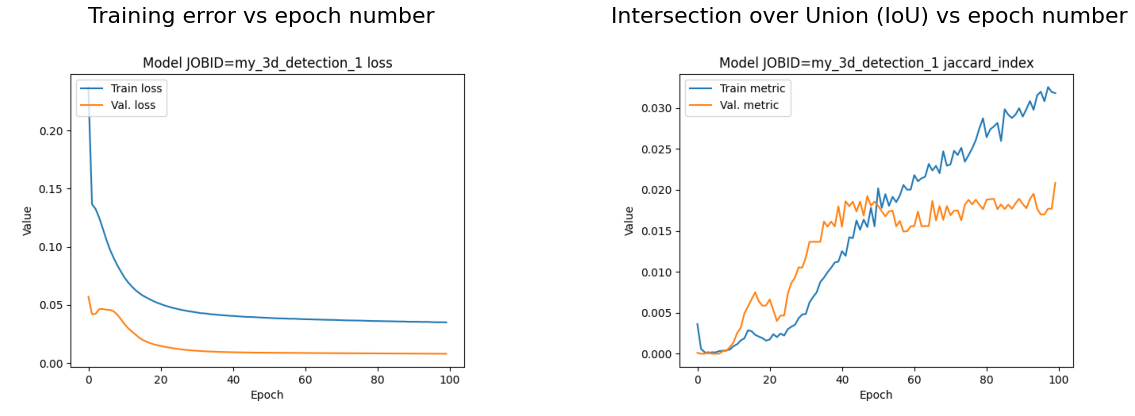

In [ ]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and IoU vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

iou_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_jaccard_index.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( iou_plot )
_ = plt.axis('off')
_= ax2.set_title( 'Intersection over Union (IoU) vs epoch number', fontdict = {'fontsize':22})

## **Visualize detection results**


In [ ]:
#@markdown ###Play to visualize results in 3D
#@markdown In the last column, associations between predition and ground truth are displayed:
#@markdown 1) Green are true positives; 2) red are false negatives and 3) blue represent false positives 

%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed
import ipywidgets as widgets
from google.colab import output
output.enable_custom_widget_manager()

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
detection_results = os.path.join(final_results, "per_image_local_max_check")
assoc_results = os.path.join(final_results, "point_associations")
test_data_mask_path = "/content/data/train/y_detection_masks"

# Show a few examples to check that they have been stored correctly 
ids_pred = sorted(next(os.walk(detection_results))[2])
ids_pred = [x for x in ids_pred if not x.endswith('.csv') ]
ids_assoc = sorted(next(os.walk(assoc_results))[2])
ids_assoc = [x for x in ids_assoc if not x.endswith('.csv') ]
ids_assoc = [x for x in ids_assoc if "_gt_ids" not in x ]
ids_assoc = [x for x in ids_assoc if "_pred_ids" not in x ]
ids_input = sorted(next(os.walk(test_data_path))[2])
ids_gt = sorted(next(os.walk(test_data_mask_path))[2])

samples_to_show = min(len(ids_input), 3)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False) 
seed(1)

test_samples = []
test_sample_preds = []
test_sample_gt = []
test_sample_assoc = []

# read 3D images again
for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_data_path, ids_input[chosen_images[i]]))
    test_samples.append(np.squeeze(aux))
    
    aux = imread(os.path.join(detection_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(np.squeeze(aux))
    
    aux = imread(os.path.join(test_data_mask_path, ids_gt[chosen_images[i]])).astype(np.uint16)
    test_sample_gt.append(np.squeeze(aux))

    aux = imread(os.path.join(assoc_results, ids_assoc[chosen_images[i]]))
    test_sample_assoc.append(np.squeeze(aux))

# function to show results in 3D within a widget
def scroll_in_z(z, j):

    plt.figure(figsize=(25,5))
    # Source
    plt.subplot(1,4,1)
    plt.axis('off')
    plt.imshow(test_samples[j][z-1], cmap='gray')
    plt.title('Source (z = ' + str(z) + ')', fontsize=15)

    # Target (Ground-truth)
    plt.subplot(1,4,2)
    plt.axis('off')
    plt.imshow(test_sample_gt[j][z-1], cmap=cmap, interpolation='nearest')
    plt.title('Ground truth (z = ' + str(z) + ')', fontsize=15)

    # Prediction
    plt.subplot(1,4,3)
    plt.axis('off')
    plt.imshow(test_sample_preds[j][z-1], cmap=cmap, interpolation='nearest')
    plt.title('Prediction (z = ' + str(z) + ')', fontsize=15)
    
    # Overlay
    plt.subplot(1,4,4)
    plt.axis('off')       
    plt.imshow(test_sample_assoc[z-1], interpolation='nearest')
    plt.title('Associations (z = ' + str(z) + ')', fontsize=15)

for j in range(samples_to_show):
    interact(scroll_in_z, z=widgets.IntSlider(min=1, max=test_sample_gt[j].shape[0], step=1, value=test_sample_gt[j].shape[0]//2), j=fixed(j));

interactive(children=(IntSlider(value=15, description='z', max=64, min=1), Output()), _dom_classes=('widget-in…

interactive(children=(IntSlider(value=15, description='z', max=64, min=1), Output()), _dom_classes=('widget-in…

interactive(children=(IntSlider(value=15, description='z', max=64, min=1), Output()), _dom_classes=('widget-in…

In [ ]:
#@markdown ###Play to display the path to the output files (one 3D TIFF label image for each input image).

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

detection_results = os.path.join(final_results, "per_image_local_max_check")

print("Output paths:")
print("    Detection files are in {}".format(detection_results))

Output paths:
    Detection files are in /content/output/my_3d_detection/results/my_3d_detection_1/per_image_local_max_check


In [ ]:
#@markdown ###Play to display the path to the association files (one 3D TIFF label image for each input image).

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

detection_assoc_results = os.path.join(final_results, "point_associations")

print("Output paths:")
print("    Detection files are in {}".format(detection_results))

Output paths:
    Detection files are in /content/output/my_3d_detection/results/my_3d_detection_1/per_image_local_max_check


## **Download detection results**

In [ ]:
#@markdown ###Play to download a zip file with all detection results in test.

from google.colab import files

!zip -q -j /content/detection.zip $detection_results/*.tif

files.download("/content/detection.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download a zip file with all detection associations results in test.
#@markdown There a few files are expected per test sample: 1) '*_fn.csv' contains the FPs; 2) 
#@markdown '*_gt_assoc.csv' contains the associations between GT and prediction (TP+FN);  
#@markdown 3) '*_gt_ids.tif' GT points labels; 4) '*_pred_ids.tif' predicted point labels; 
#@markdown 5) '*.tif' associations between GT and predictions colored (green = TP, red = FN and blue = FP)
from google.colab import files

!zip -q -j /content/detection_associations.zip $detection_assoc_results/*.tif

files.download("/content/detection_associations.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Download train model (weights and configuration file)**
If you want to **reuse the train model in the future**, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:
#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = 'model_weights_' + str( job_name ) + '_1.h5'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Advanced options**

### **Adjust detection threshold values**

In [ ]:
#@markdown ### Detection parameters:
min_value_to_be_peak = 0.5 #@param {type:"number"}
tolerance = 10 #@param {type:"number"}
remove_close_points = True #@param {type:"boolean"}
remove_close_points_radius= 3 #@param {type:"number"}


In [ ]:
#@markdown ### Play to create inference YAML with new parameters
# Transcribe model architecture

biapy_config_inference = biapy_config

# set the training to false to peform inference
biapy_config_inference['TRAIN']['ENABLE'] = False

# Detection parameters
biapy_config_inference['PROBLEM']['DETECTION']['CENTRAL_POINT_DILATION'] = central_point_dilation
biapy_config_inference['TEST']['DET_MIN_TH_TO_BE_PEAK'] = [min_value_to_be_peak]
biapy_config_inference['TEST']['DET_TOLERANCE'] = [tolerance]
biapy_config_inference['TEST']['POST_PROCESSING']['REMOVE_CLOSE_POINTS'] = remove_close_points
biapy_config_inference['TEST']['POST_PROCESSING']['REMOVE_CLOSE_POINTS_RADIUS'] = [remove_close_points_radius]


# save file
inference_file = "/content/"+str(job_name)+"_inference.yaml"

with open( inference_file, 'w') as outfile:
    yaml.dump(biapy_config_inference, outfile, default_flow_style=False)

print( "Inference configuration finished.")

### **Run inference**

In [ ]:
#@markdown ### Play to run inference on test with the new parameters

# Run the code 
os.chdir('/content/BiaPy')
!python -u main.py --config '/content/'{job_name}'_inference.yaml' --result_dir {output_path} --name {job_name} --run_id 1 --gpu 0

In [ ]:
#@markdown ###Play to visualize results in 3D
#@markdown In the last column, associations between predition and ground truth are displayed:
#@markdown 1) Green are true positives; 2) red are false negatives and 3) blue represent false positives 

%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed
import ipywidgets as widgets
from google.colab import output
output.enable_custom_widget_manager()

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
detection_results = os.path.join(final_results, "per_image_local_max_check")
assoc_results = os.path.join(final_results, "point_associations")
test_data_mask_path = "/content/data/train/y_detection_masks"

# Show a few examples to check that they have been stored correctly 
ids_pred = sorted(next(os.walk(detection_results))[2])
ids_pred = [x for x in ids_pred if not x.endswith('.csv') ]
ids_assoc = sorted(next(os.walk(assoc_results))[2])
ids_assoc = [x for x in ids_assoc if not x.endswith('.csv') ]
ids_assoc = [x for x in ids_assoc if "_gt_ids" not in x ]
ids_assoc = [x for x in ids_assoc if "_pred_ids" not in x ]
ids_input = sorted(next(os.walk(test_data_path))[2])
ids_gt = sorted(next(os.walk(test_data_mask_path))[2])

samples_to_show = min(len(ids_input), 3)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False) 
seed(1)

test_samples = []
test_sample_preds = []
test_sample_gt = []
test_sample_assoc = []

# read 3D images again
for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_data_path, ids_input[chosen_images[i]]))
    test_samples.append(np.squeeze(aux))
    
    aux = imread(os.path.join(detection_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(np.squeeze(aux))
    
    aux = imread(os.path.join(test_data_mask_path, ids_gt[chosen_images[i]])).astype(np.uint16)
    test_sample_gt.append(np.squeeze(aux))

    aux = imread(os.path.join(assoc_results, ids_assoc[chosen_images[i]]))
    test_sample_assoc.append(np.squeeze(aux))

# function to show results in 3D within a widget
def scroll_in_z(z, j):

    plt.figure(figsize=(25,5))
    # Source
    plt.subplot(1,4,1)
    plt.axis('off')
    plt.imshow(test_samples[j][z-1], cmap='gray')
    plt.title('Source (z = ' + str(z) + ')', fontsize=15)

    # Target (Ground-truth)
    plt.subplot(1,4,2)
    plt.axis('off')
    plt.imshow(test_sample_gt[j][z-1], cmap=cmap, interpolation='nearest')
    plt.title('Ground truth (z = ' + str(z) + ')', fontsize=15)

    # Prediction
    plt.subplot(1,4,3)
    plt.axis('off')
    plt.imshow(test_sample_preds[j][z-1], cmap=cmap, interpolation='nearest')
    plt.title('Prediction (z = ' + str(z) + ')', fontsize=15)
    
    # Overlay
    plt.subplot(1,4,4)
    plt.axis('off')       
    plt.imshow(test_sample_assoc[z-1], interpolation='nearest')
    plt.title('Associations (z = ' + str(z) + ')', fontsize=15)

for j in range(samples_to_show):
    interact(scroll_in_z, z=widgets.IntSlider(min=1, max=test_sample_gt[j].shape[0], step=1, value=test_sample_gt[j].shape[0]//2), j=fixed(j));

## **Acknowledgments**
We would like to acknowledge the inspiration provided by the excellent [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki). In particular, we have reused some of their descriptions of metrics and parameters, as well as their 3D visualization widget code from their [U-Net 3D notebook](https://colab.research.google.com/github/HenriquesLab/ZeroCostDL4Mic/blob/master/Colab_notebooks/U-Net_3D_ZeroCostDL4Mic.ipynb).